# Particle size analysis using a pre-trained model
In this demo, you will learn how to:
* use a pre-trained model to analyse a set of images
* post-process the analysis results
* visualize the analysis results

## Imports

In [1]:
from IPython.display import display
from IPython.display import Image

from pathlib import Path
import shutil

import pandas as pd

from paddle.lightning_modules import LightningMaskRCNN
from paddle.deployment import run_model_on_dataset
from paddle.data import MaskRCNNDataset
from paddle.postprocessing import (
    Postprocessor,
    FilterBorderInstances,
    SaveMaskProperties,
    FilterScore,
    SaveVisualization,
    calculate_area_equivalent_diameters,
    calculate_maximum_feret_diameters,
    calculate_minimum_feret_diameters,
)
from paddle.utilities import download_file, unzip
from paddle.visualization import plot_particle_size_distributions

## Preparations
For the demonstration, we need to have some example data, and a model that was trained on said data.


### Download pretrained model

In [2]:
model_checkpoint_url = "https://uni-duisburg-essen.sciebo.de/s/qSiv7c4WyGfTAly/download"
model_checkpoint_path = Path("..") / "maskrcnn_resnet50_mpac.ckpt"
download_file(model_checkpoint_url, model_checkpoint_path)

100%|██████████| 176M/176M [00:22<00:00, 7.84MiB/s] 


### Download and extract data set

In [3]:
data_zip_url = "https://uni-duisburg-essen.sciebo.de/s/26xZ3VBcsA0SnC3/download"
data_zip_path = Path("..") / "mpac.zip"
data_root = Path("..") / "data"

download_file(data_zip_url, data_zip_path)
unzip(data_zip_path, data_root)

100%|██████████| 230M/230M [00:33<00:00, 6.78MiB/s] 


## Load model

In [4]:
model = LightningMaskRCNN.load_from_checkpoint(model_checkpoint_path)

## Perform analysis

Choose a subset of the MPAC dataset for the analysis:

In [5]:
subset = "test_s06"

Define an output path, where the analysis results are going to be saved:

In [6]:
output_root = Path("output")

For the purpose of this demo, remove the output directory (if it already exists). Otherwise,
`run_model_on_dataset` would raise an exception, so that it does not overwrite any data:

In [7]:
shutil.rmtree(output_root, ignore_errors=True)

Run the analysis:

In [8]:
run_model_on_dataset(model, output_root, data_root, subset)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

## Post-process results
So far, we only have raw outputs, i.e. a new data set, which contains input images and detection
masks, scores and classes. Therefore, we now post-process our results using the `Postprocessor`
class.

First, we create a dataset that holds our raw detections:

In [9]:
result_data_set = MaskRCNNDataset(
    output_root,
    subset=subset
)

Then, we set up the post processing. To do so, we define a sequence of post processing steps:

1. Remove instances that touch the image border.

In [10]:
filter_border_instances = FilterBorderInstances(border_width=3)

2. Measure and save properties of the instance masks, using the specified functions (these could
be custom functions as well):

In [11]:
save_mask_properties = SaveMaskProperties(
    output_file_path=output_root / subset / "measurements.csv",
    measurement_fcns={
        "equivalent_diameter_area": calculate_area_equivalent_diameters,
        "feret_diameter_min": calculate_minimum_feret_diameters,
        "feret_diameter_max": calculate_maximum_feret_diameters,
    }
)

3. Filter detections with a `score < 0.9`, to unclutter our visualization.

In [12]:
score_threshold = FilterScore(threshold=0.9)

4. Save visualizations of the detections:

In [13]:
save_visualization = SaveVisualization(
    output_root=output_root / subset,
    do_display_box=False,
    do_display_score=False,
    do_display_label=False,
    line_width=2,
    map_label_to_class_name=result_data_set.map_label_to_class_name
)

Now, put everything together:

In [14]:
post_processing_steps = [
    filter_border_instances,
    save_mask_properties,
    score_threshold,
    save_visualization
]

Next, we create and run a `Postprocessor` instance.

In [15]:
postprocessor = Postprocessor(result_data_set, post_processing_steps)
postprocessor.run()

Postprocessing: 100%|██████████| 16/16 [00:20<00:00,  1.27s/it]


Finally, we log the utilized setup of postprocessing steps to a file:

In [16]:
postprocessor.log(output_root / subset)

## Evaluate results

### Display an example detection

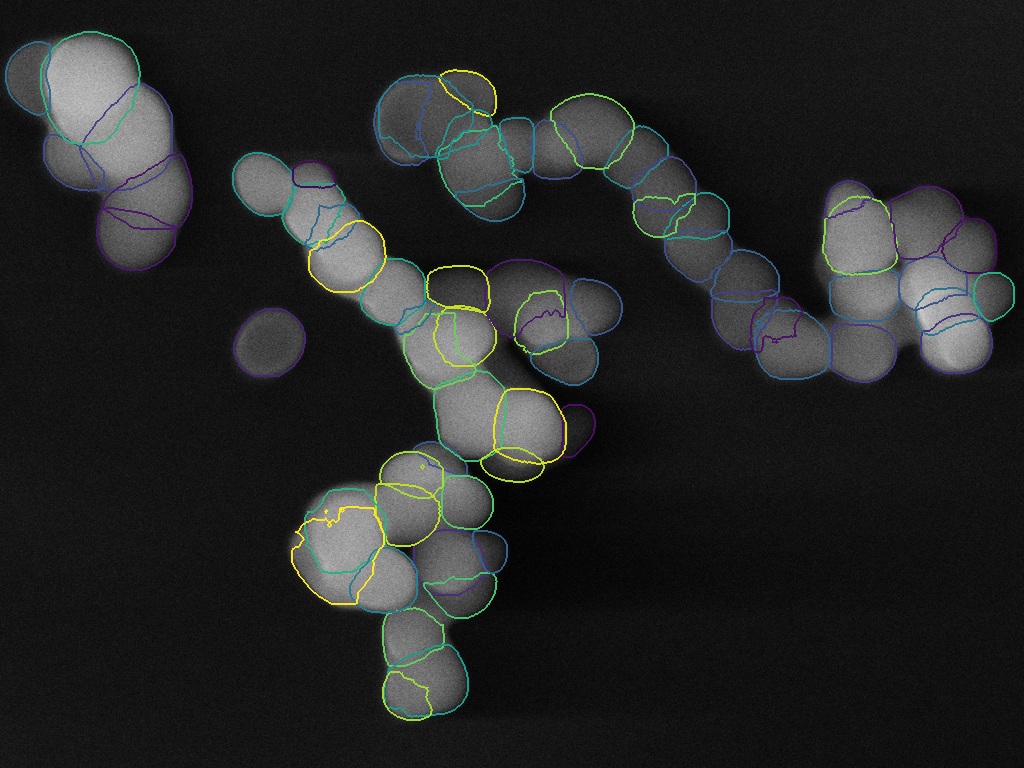

In [17]:
example_detection = Image(filename=output_root / subset / "visualization_000002.png")
display(example_detection)

### Print measurement results

In [18]:
measurement_results = pd.read_csv(
    output_root / subset / "measurements.csv",
    dtype={"image_name": str}
)
display(measurement_results)

,equivalent_diameter_area,feret_diameter_min,feret_diameter_max,score,label,image_name
0,48.243983,47.000000,50.119856,0.999490,1,000001
1,68.942028,60.981723,78.032045,0.998708,1,000001
2,55.209922,49.392548,62.968246,0.998658,1,000001
3,43.992319,32.071837,62.817195,0.997826,1,000001
4,65.270664,61.329875,76.655072,0.997076,1,000001
...,...,...,...,...,...,...
1069,44.638771,39.597980,53.310412,0.999300,1,000016
1070,58.403842,57.553453,64.257295,0.999216,1,000016
1071,53.808426,46.215908,68.154237,0.998545,1,000016
1072,48.951372,39.775941,63.600314,0.998449,1,000016


### Plot measurement results

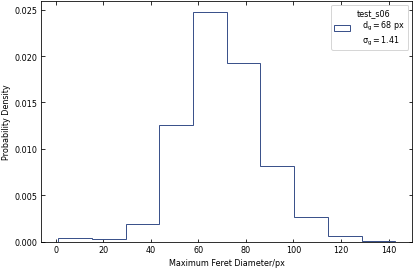

In [19]:
plot_particle_size_distributions(
    particle_size_lists=[measurement_results["feret_diameter_max"]],
    score_lists=[measurement_results["score"]],
    measurand_name="Maximum Feret Diameter",
    labels=[subset]
)